In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 8.2 MB/s 


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
dataset = sg.datasets.CiteSeer()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)
        Features: none


In [14]:
node_subjects.value_counts().to_frame()

,subject
DB,701
IR,668
Agents,596
ML,590
HCI,508
AI,249


In [15]:
#جداسازی داده ها
train_subjects, test_subjects = model_selection.train_test_split( node_subjects, train_size=140, test_size=None, stratify=node_subjects)

val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)

In [16]:
#تبدیل به بردار (one-hot)
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)
print (test_targets[6])

[0 0 1 0 0 0]


In [17]:
#این کلاس در واقع اطلاعات گراف را برای ورودی مدل میتواند آماده کند
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [18]:
#داده های ورودی را اماده میکنیم
train_gen = generator.flow(train_subjects.index, train_targets)
train_gen[0,5,4]

([array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 1., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
  array([[3257, 1440, 1105,  218, 3184, 1038,  474, 1617, 2065, 3161,  943,
          1243, 2080, 2788, 2911, 1947, 2253,  106, 1125, 3010, 2088, 1253,
          1176,  315, 1620, 2565, 2072, 1681, 2905, 1109,  973, 2705,  282,
          2024, 3167,  574, 2423,  494, 2241, 2120,  765, 3081, 2780, 2841,
           303, 1601, 1290, 2875, 2243, 1062,  525,  902, 1310, 3035,  627,
           117, 1449, 2941,  539,    7, 1178, 2752, 3050, 3064, 2414, 1027,
          2375, 1347,  758, 1781, 2570, 2487, 1015, 2369, 2316, 2232,  132,
           890, 2044, 2959, 2706, 1116, 3282,   83,  885,  991, 1050,  470,
          2205,  996, 2785, 1122,  938, 2212, 1900, 2983, 2094,  493, 2711,
          1725, 1287, 2191, 2524, 169

In [19]:
#.مشخصات مدل را می دهیم.مدل شامل دولایه که هرکدام 16 نود دارند و فعالسازشان رلیو است می باشد.نصف داده هارا هم به عنوان دراپ اوت در نظر میگیریم ومدل را ایجاد میکنیم
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5)

In [20]:
#خروجی یک بردار 16 بعدی را برای هر گره در هنگام اموزش یا پیش بینی نگه میدارد.وپیش بینی واقعی هرگره از این بردار محاسبه میشود.یک لایه اضافی با یک نود هم دارد که از سافت مکس استفاده میکند برای محاسبه احتمال هرکلاس
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [22]:
#prediction برابر است با بیشترین مقدار سافت مکس در واقع یک لایه اضافه کردیم با فعالساز سافت مکس که برحسب ایکس اوت برچسب نود را پیش بینی کند
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [23]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
#میخواهیم عملکرد را در داده های ارزیابی هم حفظ کنیم ،یعنی یک مولد داده های دیگر هم باید ایجاد کنیم برای داده های ارزیابی
val_gen = generator.flow(val_subjects.index, val_targets)

In [24]:
#یک مقدار توقف برای ایپوک هاست که اگر دقت بهتر نشد دیگه ادامه ندهد
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=100, restore_best_weights=True)

In [27]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 4s - loss: 1.8120 - acc: 0.1143 - val_loss: 1.7754 - val_acc: 0.3300 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 1s - loss: 1.7492 - acc: 0.4286 - val_loss: 1.7305 - val_acc: 0.4920 - 557ms/epoch - 557ms/step
Epoch 3/200
1/1 - 0s - loss: 1.6692 - acc: 0.6500 - val_loss: 1.6594 - val_acc: 0.5360 - 427ms/epoch - 427ms/step
Epoch 4/200
1/1 - 0s - loss: 1.5437 - acc: 0.7071 - val_loss: 1.5775 - val_acc: 0.5340 - 344ms/epoch - 344ms/step
Epoch 5/200
1/1 - 0s - loss: 1.4016 - acc: 0.6643 - val_loss: 1.4922 - val_acc: 0.5140 - 338ms/epoch - 338ms/step
Epoch 6/200
1/1 - 0s - loss: 1.2315 - acc: 0.7357 - val_loss: 1.4090 - val_acc: 0.5080 - 294ms/epoch - 294ms/step
Epoch 7/200
1/1 - 0s - loss: 1.1024 - acc: 0.7143 - val_loss: 1.3294 - val_acc: 0.5200 - 302ms/epoch - 302ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9455 - acc: 0.7571 - val_loss: 1.2538 - val_acc: 0.5520 - 362ms/epoch - 362ms/step
Epoch 9/200
1/1 - 0s - loss: 0.8761 - acc: 0.7786 - val_loss: 1.1874 - val_acc: 0.5960 - 356ms

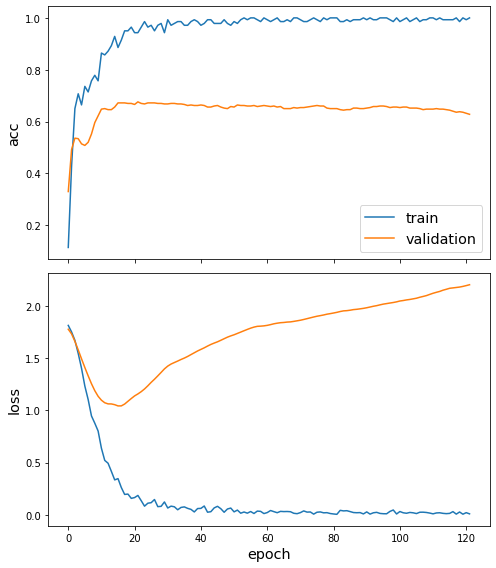

In [28]:
sg.utils.plot_history(history)

In [29]:
#مولد تولید داده های تست
test_gen = generator.flow(test_subjects.index, test_targets)

In [30]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 103ms/step - loss: 1.1281 - acc: 0.6714

Test Set Metrics:
	loss: 1.1281
	acc: 0.6714


In [31]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [32]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [33]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
100157,Agents,Agents
100598,ML,IR
105684,Agents,Agents
11099,IR,DB
114091,IR,AI
11510,AI,AI
115971,Agents,Agents
117999,IR,IR
120432,Agents,AI
126894,Agents,HCI


In [34]:
batch_size = 50
num_samples = [10, 5]
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [35]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
test_gen = generator.flow(test_subjects.index, test_targets)


In [37]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
3/3 - 7s - loss: 1.7705 - acc: 0.2071 - val_loss: 1.6555 - val_acc: 0.4345 - 7s/epoch - 2s/step
Epoch 2/20
3/3 - 4s - loss: 1.4996 - acc: 0.6857 - val_loss: 1.5593 - val_acc: 0.5487 - 4s/epoch - 1s/step
Epoch 3/20
3/3 - 4s - loss: 1.3337 - acc: 0.9000 - val_loss: 1.4850 - val_acc: 0.5939 - 4s/epoch - 1s/step
Epoch 4/20
3/3 - 4s - loss: 1.2302 - acc: 0.8857 - val_loss: 1.4251 - val_acc: 0.6243 - 4s/epoch - 1s/step
Epoch 5/20
3/3 - 6s - loss: 1.1397 - acc: 0.9357 - val_loss: 1.3741 - val_acc: 0.6422 - 6s/epoch - 2s/step
Epoch 6/20
3/3 - 5s - loss: 1.0492 - acc: 0.9357 - val_loss: 1.3367 - val_acc: 0.6463 - 5s/epoch - 2s/step
Epoch 7/20
3/3 - 5s - loss: 0.9815 - acc: 0.9500 - val_loss: 1.3031 - val_acc: 0.6475 - 5s/epoch - 2s/step
Epoch 8/20
3/3 - 6s - loss: 0.9238 - acc: 0.9500 - val_loss: 1.2728 - val_acc: 0.6508 - 6s/epoch - 2s/step
Epoch 9/20
3/3 - 5s - loss: 0.8558 - acc: 0.9500 - val_loss: 1.2483 - val_acc: 0.6519 - 5s/epoch - 2s/step
Epoch 10/20
3/3 - 4s - loss: 0.7961 -

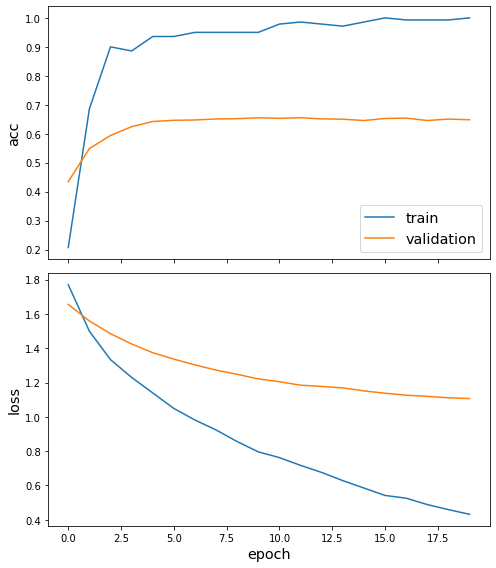

In [38]:
sg.utils.plot_history(history)


In [39]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

54/54 [==============================] - 4s 71ms/step - loss: 1.1029 - acc: 0.6482

Test Set Metrics:
	loss: 1.1029
	acc: 0.6482


In [40]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions1 = target_encoding.inverse_transform(all_predictions)


df = pd.DataFrame({"Predicted": node_predictions1, "True": node_subjects})
df.head(20)

,Predicted,True
100157,Agents,Agents
100598,ML,IR
105684,Agents,Agents
11099,IR,DB
114091,IR,AI
11510,AI,AI
115971,Agents,Agents
117999,IR,IR
120432,Agents,AI
126894,Agents,HCI


In [41]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["relu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()


In [42]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
val_gen = generator.flow(val_subjects.index, val_targets)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [44]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 9s - loss: 1.8216 - acc: 0.1786 - val_loss: 1.7376 - val_acc: 0.3720 - 9s/epoch - 9s/step
Epoch 2/50
1/1 - 1s - loss: 1.7133 - acc: 0.3214 - val_loss: 1.6811 - val_acc: 0.4860 - 932ms/epoch - 932ms/step
Epoch 3/50
1/1 - 1s - loss: 1.6205 - acc: 0.4786 - val_loss: 1.6192 - val_acc: 0.5560 - 752ms/epoch - 752ms/step
Epoch 4/50
1/1 - 1s - loss: 1.4909 - acc: 0.5571 - val_loss: 1.5523 - val_acc: 0.5820 - 757ms/epoch - 757ms/step
Epoch 5/50
1/1 - 1s - loss: 1.4190 - acc: 0.6357 - val_loss: 1.4847 - val_acc: 0.6020 - 948ms/epoch - 948ms/step
Epoch 6/50
1/1 - 1s - loss: 1.3142 - acc: 0.6000 - val_loss: 1.4195 - val_acc: 0.6200 - 929ms/epoch - 929ms/step
Epoch 7/50
1/1 - 1s - loss: 1.2733 - acc: 0.5857 - val_loss: 1.3594 - val_acc: 0.6300 - 767ms/epoch - 767ms/step
Epoch 8/50
1/1 - 1s - loss: 1.1018 - acc: 0.7071 - val_loss: 1.3042 - val_acc: 0.6380 - 788ms/epoch - 788ms/step
Epoch 9/50
1/1 - 1s - loss: 1.0160 - acc: 0.7714 - val_loss: 1.2546 - val_acc: 0.6400 - 1s/epoch - 1s/

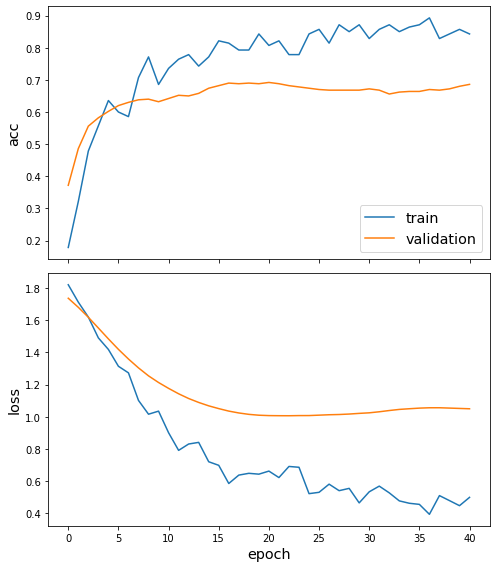

In [45]:
sg.utils.plot_history(history)


In [46]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 177ms/step - loss: 1.0485 - acc: 0.6751

Test Set Metrics:
	loss: 1.0485
	acc: 0.6751


In [47]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
100157,Agents,Agents
100598,IR,IR
105684,Agents,Agents
11099,IR,DB
114091,Agents,AI
11510,AI,AI
115971,Agents,Agents
117999,IR,IR
120432,Agents,AI
126894,Agents,HCI
